# Predicting NYC Air Quality from Weather and Traffic Patterns


**Author**: Xiaolong Zhou

**Date**: Dec 4, 2025

## Problem Statement
Air pollution is always one of the hottest topics when talking about climate change, as it is one of the most visible and harmful consequences of human activity intensified by it. While emissions primarily come from vehicles, industry, and energy production, weather conditions also affect the pollutants accumulate and disperse. By studying the relationships between these factors, we can inform traffic control and urban planning policies. For instance, we can better apply traffic restrictions or public-transit interventions in a most effective way.


The prevailing hypothesis is that local vehicular traffic is the primary driver of daily pollution fluctuations. This project aims to predict next-day AQI using a combination of **Traffic Volume** (from NYC Open Data) and **Weather Variables** (from NOAA/Meteostat).

## Methodology
1. **Data Collection:** 
   - Traffic: NYC Open Data (Automated Traffic Volume Counts).
   - Air Quality: EPA AirData (Daily PM2.5 AQI).
   - Weather: Meteostat (Central Park Station: Wind, Pressure, Temp).
2. **Feature Engineering:** 
   - Created physics-based features like "Traffic Index" (Traffic/Wind) and "Temperature Change".
   - Implemented lag and rolling averages to capture pollution inertia.
3. **Modeling:** 
   - Comparison of Linear Regression (Baseline) vs. XGBoost (Non-linear).
   - Evaluation using R², RMSE, and Directional Accuracy.

In [171]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
from meteostat import Point, Daily
from sodapy import Socrata
from datetime import datetime
import requests
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from codecarbon import EmissionsTracker
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

## Carbon Tracker Initiating..

In [172]:
tracker = EmissionsTracker(project_name="AQI_Prediction_Project")
tracker.start()

print("Environment Setup Complete. Carbon tracking started.")

[codecarbon WARNING @ 04:44:30] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 04:44:30] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 04:44:30] [setup] RAM Tracking...
[codecarbon INFO @ 04:44:30] [setup] CPU Tracking...
[codecarbon WARNING @ 04:44:30] We saw that you have a Apple M4 but we don't know it. Please contact us.
[codecarbon WARNING @ 04:44:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 04:44:31] CPU Model on constant consumption mode: Apple M4
[codecarbon WARNING @ 04:44:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 04:44:31] [setup] GPU Tracking...
[codecarbon INFO @ 04:44:31] No GPU found.
[codecarbon INFO @ 04:44:31] The below tracking methods have been set up:


Environment Setup Complete. Carbon tracking started.


## Data Collecting

### Traffic data

In [173]:
def process_traffic_data(file_path):
    print("Processing Traffic Data....")
    df = pd.read_csv(
    file_path,
    low_memory=False
    )
    
    # Standardize column names (lowercase)
    df.columns = [c.lower().strip() for c in df.columns]
    
    # Create Date Column
    print("Creating Date column...")
    df['Date'] = pd.to_datetime(
        df['yr'].astype(str) + '-' + 
        df['m'].astype(str).str.zfill(2) + '-' + 
        df['d'].astype(str).str.zfill(2)
    )
    
    # make vol numeric
    df['vol'] = pd.to_numeric(df['vol'], errors='coerce')
    
    daily_traffic = df.groupby('Date')['vol'].sum().reset_index()
    
    # Rename for clarity
    daily_traffic.rename(columns={'vol': 'Traffic_Vol'}, inplace=True)
    
    print(f"Traffic Data Processed: {len(daily_traffic)} days found.")
    return daily_traffic

### Air quality data (EPA)

In [174]:
def process_air_data(file_paths):
    print("Processing Air Quality Data...")
    dfs = []
    for f in file_paths:
        # Load EPA CSV
        temp = pd.read_csv(f)
        

        cols = {c: c.strip() for c in temp.columns}
        temp.rename(columns=cols, inplace=True)
        
        if 'Date' in temp.columns and 'Daily AQI Value' in temp.columns:
            temp = temp[['Date', 'Daily AQI Value']]
            temp.columns = ['Date', 'AQI']
            dfs.append(temp)
        else:
            print(f"Skipping {f}: Could not find 'Date' or 'Daily AQI Value' columns.")
            
    if not dfs:
        raise ValueError("No valid Air Quality data found.")
    
    full_df = pd.concat(dfs)
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    
    # Aggregate: Average AQI across all NYC sites for the day
    daily_aqi = full_df.groupby('Date')['AQI'].mean().reset_index()
    
    print(f"Air Data Processed: {len(daily_aqi)} days found.")
    return daily_aqi

### Weather data

In [ ]:
def get_weather(start_date, end_date):
    print("Fetching Weather Data...")
    # Central Park Coordinates
    location = Point(40.785091, -73.968285)
    
    data = Daily(location, start_date, end_date)
    data = data.fetch()
    
    data = data.reset_index()
    data = data.rename(columns={
        'time': 'Date', 
        'tavg': 'Temp_Avg', 
        'prcp': 'Precipitation', 
        'wspd': 'Wind_Speed',
        'pres': 'Pressure'
        #'dwpt': 'Dew_Point' 
        #'rhum': 'Humidity'
    })
    
    # Select only what is needed
    data = data[['Date', 'Temp_Avg', 'Precipitation', 'Wind_Speed', 'Pressure']]
    
    # Fill NaN
    data = data.ffill().bfill()
    
    return data

### Data merging

In [176]:
traffic_file = 'Data/nyc_traffic.csv'
air_files = ['Data/aqi_2021.csv', 'Data/aqi_2022.csv', 'Data/aqi_2023.csv']

try:
    # Process Traffic
    df_traffic = process_traffic_data(traffic_file)
    
    # Process Air
    df_air = process_air_data(air_files)
    
    # Determine Date Range for Weather
    min_date = max(df_traffic['Date'].min(), df_air['Date'].min())
    max_date = min(df_traffic['Date'].max(), df_air['Date'].max())
    
    print(f"Merging Data from {min_date.date()} to {max_date.date()}")
    
    # Get Weather
    df_weather = get_weather(min_date, max_date)
    
    # Merge All

    step1 = pd.merge(df_traffic, df_weather, on='Date', how='inner')
    final_df = pd.merge(step1, df_air, on='Date', how='inner')
    
    # Sort and Save
    final_df = final_df.sort_values('Date')
    final_df.to_csv('final_model_data.csv', index=False)
    
    print("SUCCESS! 'final_model_data.csv' created.")
    print(final_df.head())
    
except Exception as e:
    print(f"Error: {e}")

Processing Traffic Data....
Creating Date column...
Traffic Data Processed: 5207 days found.
Processing Air Quality Data...
Air Data Processed: 1095 days found.
Merging Data from 2021-01-01 to 2023-12-31
Fetching Weather Data...
SUCCESS! 'final_model_data.csv' created.
        Date  Traffic_Vol  Temp_Avg  Precipitation  Wind_Speed  Pressure  \
0 2021-01-04      30067.0       3.4            0.6        11.2    1015.0   
1 2021-01-05      31570.0       3.4            0.2         9.5    1013.6   
2 2021-01-06      31025.0       2.6            0.0        15.5    1016.0   
3 2021-01-07      31488.0       1.5            0.0        13.7    1019.2   
4 2021-01-08      30893.0      -0.1            0.0        12.3    1016.2   

         AQI  
0  36.441860  
1  40.851852  
2  36.750000  
3  24.916667  
4  34.827586  


## Model Implementation

### Feature Engineering


I use daily traffic data and aggregate it to a city-wide volume index and align this with EPA daily AQI readings. 

Before modeling, I test the statistical relationship between features and the target (Next Day AQI). 

**Key Hypothesis Test:** Does Traffic Volume correlate with AQI?

*Note:* I filter out days with AQI > 150 to remove extreme outliers.

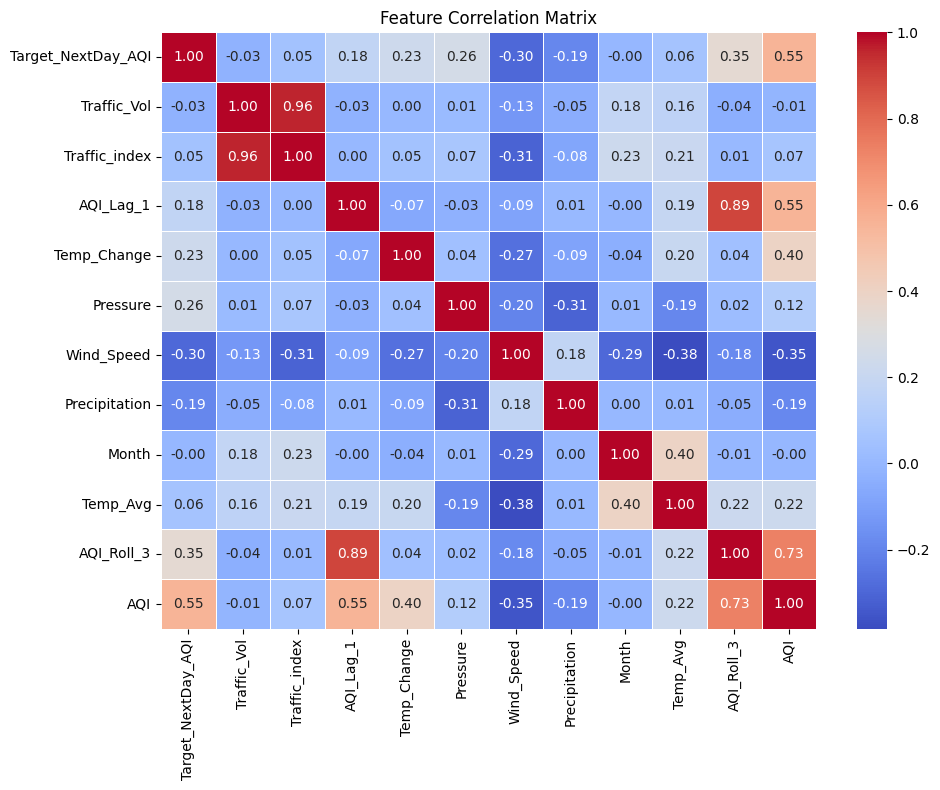


--- CORRELATION WITH TARGET ---
Target_NextDay_AQI    1.000000
AQI                   0.554573
AQI_Roll_3            0.346715
Pressure              0.259274
Temp_Change           0.228264
AQI_Lag_1             0.175852
Temp_Avg              0.058710
Traffic_index         0.053090
Month                -0.004257
Traffic_Vol          -0.026743
Precipitation        -0.192907
Wind_Speed           -0.296704
Name: Target_NextDay_AQI, dtype: float64


In [ ]:
df = pd.read_csv('final_model_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Traffic_Vol'] = pd.to_numeric(df['Traffic_Vol'], errors='coerce')
df = df.sort_values('Date')
# applied a filter of AQI < 150. 
# This threshold marks the EPA's transition to the 'Unhealthy' category. In NYC, values exceeding 150 are statistically rare.
df = df[df['AQI'] <= 150]

# Feature Engineering
df['Target_NextDay_AQI'] = df['AQI'].shift(-1)
df['AQI_Lag_1'] = df['AQI'].shift(1)
df['AQI_Roll_3'] = df['AQI'].rolling(window=3).mean()
df['Month'] = df['Date'].dt.month
df['Traffic_index'] = df['Traffic_Vol'] / (df['Wind_Speed'] + 0.1)
df['Temp_Change'] = df['Temp_Avg'] - df['Temp_Avg'].shift(1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean = df.dropna().reset_index(drop=True)

features_to_test = ['Target_NextDay_AQI', 'Traffic_Vol', 'Traffic_index', 
                    'AQI_Lag_1', 'Temp_Change', 'Pressure', 'Wind_Speed', 'Precipitation', 'Month', 'Temp_Avg', 'AQI_Roll_3', 'AQI']

corr_matrix = df_clean[features_to_test].corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300)
plt.show()

print("\n--- CORRELATION WITH TARGET ---")
print(corr_matrix['Target_NextDay_AQI'].sort_values(ascending=False))

### The following variables were selected for the final model:

| Feature Name | Type | Description |
| :--- | :--- | :--- |
| **Traffic_Vol** | Raw |  Main topic of this project, though shows low correlation, is chosen to prove its relationship with air quality. This is daily aggregated traffic volume from NYC Automated Traffic Recorders. Represents the potential local emission source. |
| **Wind_Speed** | Raw | Average daily wind speed. |
| **Precipitation** | Raw | Precipitation of the day. Rain can both improve or worsen the air quality depends on the size of rainfall. |
| **Pressure** | Raw | Sea-level air pressure. High pressure systems can trap pollutants near the ground. |
| **Temp_Avg** | Raw | Average temperature of the day. |
| **Traffic_Index** | **Engineered** | Calculated as `Traffic_Vol / (Wind_Speed + 0.1)`. A high traffic day with low wind could cause pollutant to stay in air. |
| **Temp_Change** | **Engineered** | The difference in temperature from the previous day (`T_today - T_yesterday`). Rapid temperature drops often signal cold wind. |
| **AQI** | Raw | This is today's PM2.5 AQI, main feature to predict tomorrow, reasonable because a bad air condition is likely to persist in days. |
| **AQI_Lag_1** | **Engineered** | Yesterday's AQI value. Same reason as AQI. |
| **AQI_Roll_3** | **Engineered** | 3-Day Rolling Average of AQI. Smooths out daily noise to capture the underlying pollution baseline. |

In [178]:
# Dropping Month becuase it has a very low correlation with the target
features = ['Traffic_Vol', 'Traffic_index', 'Temp_Change', 'Pressure', 'Wind_Speed', 
            'AQI', 'AQI_Lag_1', 'AQI_Roll_3', 'Precipitation', 'Temp_Avg']
target = 'Target_NextDay_AQI'

X = df_clean[features]
y = df_clean[target]

# Split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
test_dates = df_clean['Date'].iloc[split:]

### Baseline Linear Regression Model

Two models are being deploied:

1. **Linear Regression:** To establish a baseline and test for linear relationships.

2. **XGBoost Regressor:** To capture potential non-linear interactions between weather and traffic.

In [179]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

lr_r2 = r2_score(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))

print("\n------------------------------------------------")
print("BASELINE MODEL (Linear Regression)")
print(f"R²: {lr_r2:.3f} | RMSE: {lr_rmse:.2f}")
print("------------------------------------------------")


------------------------------------------------
BASELINE MODEL (Linear Regression)
R²: 0.319 | RMSE: 16.51
------------------------------------------------


### XGBoost Model Implementation

In [180]:
print(df_weather.head())

        Date  Temp_Avg  Precipitation  Wind_Speed  Pressure
0 2021-01-01       2.5           17.3        13.2    1029.4
1 2021-01-02       5.4            6.1        17.5    1012.5
2 2021-01-03       2.4            5.2        15.6    1017.3
3 2021-01-04       3.4            0.6        11.2    1015.0
4 2021-01-05       3.4            0.2         9.5    1013.6


**Time Series Split** validation to ensure no "leak" future data into the training set.

In [181]:
# HYPERPARAMETER TUNING (Grid Search)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
tscv = TimeSeriesSplit(n_splits=3) 

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters Found: {grid_search.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[codecarbon INFO @ 04:44:38] Energy consumed for RAM : 0.002213 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:44:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 04:44:38] Energy consumed for All CPU : 0.031349 kWh
[codecarbon INFO @ 04:44:38] 0.033562 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 04:44:49] Energy consumed for RAM : 0.000013 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:44:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 04:44:49] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 04:44:49] 0.000190 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 04:44:53] Energy consumed for RAM : 0.002225 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:44:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 04:44:53] Energy consumed for All CPU : 


Best Parameters Found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [182]:
# FINAL OPTIMIZED XGBOOST MODEL
xgb_preds = best_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

print("\n------------------------------------------------")
print("FINAL OPTIMIZED XGBOOST MODEL")
print(f"R²: {xgb_r2:.3f} | RMSE: {xgb_rmse:.2f}")
print(f"Improvement over Baseline: {((xgb_r2 - lr_r2)/abs(lr_r2))*100:.1f}%")
print("------------------------------------------------")


------------------------------------------------
FINAL OPTIMIZED XGBOOST MODEL
R²: 0.229 | RMSE: 17.57
Improvement over Baseline: -28.4%
------------------------------------------------


### Evaluation

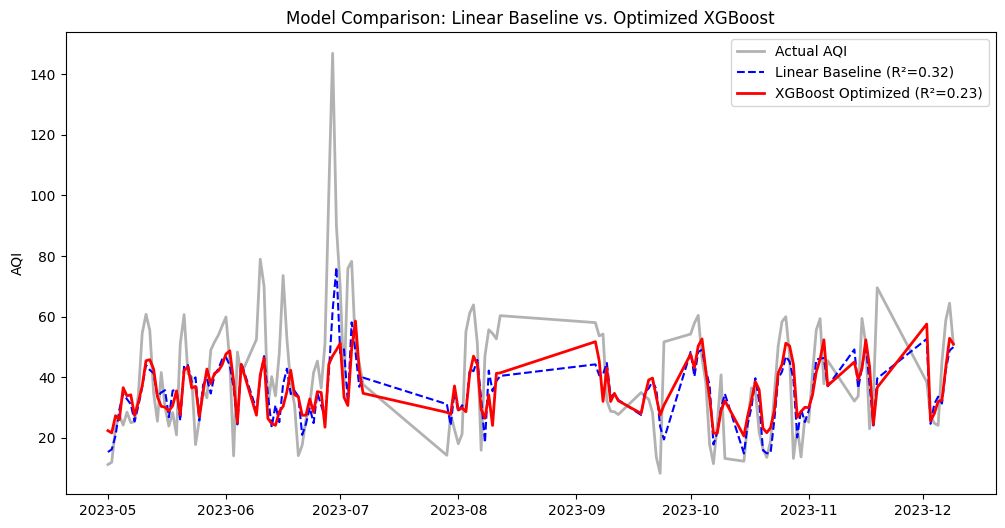

In [183]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual AQI', color='black', alpha=0.3, linewidth=2)
plt.plot(test_dates, lr_preds, label=f'Linear Baseline (R²={lr_r2:.2f})', color='blue', linestyle='--')
plt.plot(test_dates, xgb_preds, label=f'XGBoost Optimized (R²={xgb_r2:.2f})', color='red', linewidth=2)
plt.title("Model Comparison: Linear Baseline vs. Optimized XGBoost")
plt.legend()
plt.ylabel("AQI")
plt.savefig("final_comparison_plot.png", dpi=300)
plt.show()

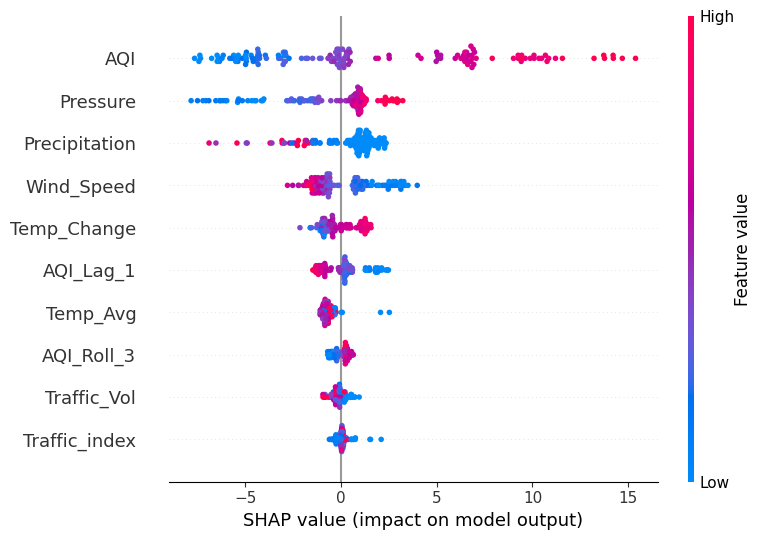

In [184]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test, show=True)

In addition to the standard regression metrics like RMSE and R squared, directional accuracy is introduced here to evaluate the model's practical utility. While R squared measures the model's ability to predict the exact value of aqi, directional accuracy assess its ability to detect trends: whether or not the air quality is going to improve tomorrow. This is introduced because the model performance on predicting exact air quality is not so satisfying. Indeed, given the stochastic nature of atmospheric dynamics, predicting the precise peak of a pollution spike is computationally difficult. However, I discovered from the comparison plot that, although the model may underestimate extreme magnitudes, it captures the trend of targeted data.

Also, for public health policy and early warning systems, correctly forecasting the direction of change could still be effective to help policymakers to anticipate and mitigate emerging air quality events.

Formula used here:
$$
\mathrm{DA}
= \frac{1}{N}
\sum_{t=1}^{N}
\mathbf{1}\!\left(
\operatorname{sign}(y_{t} - y_{t-1})
=
\operatorname{sign}(\hat{y}_{t} - y_{t-1})
\right)
$$

Let $y_t$ denote the true AQI on day $t$ and $\hat{y}_t$ the model's prediction for day $t$.
Directional accuracy measures how often the model correctly predicts whether air quality will
improve or worsen relative to today:


In [190]:
actual_direction = np.sign(y_test.values - X_test['AQI'].values)
pred_direction = np.sign(xgb_preds - X_test['AQI'].values)
directional_accuracy = np.mean(actual_direction == pred_direction) * 100

print("\n------------------------------------------------")
print("FINAL RESULTS")
print("------------------------------------------------")
print(f"Linear Regression R²: {lr_r2:.3f}")
print(f"XGBoost R²:           {xgb_r2:.3f}")
print(f"Directional Accuracy: {directional_accuracy:.1f}")
print("------------------------------------------------")


------------------------------------------------
FINAL RESULTS
------------------------------------------------
Linear Regression R²: 0.319
XGBoost R²:           0.229
Directional Accuracy: 60.6
------------------------------------------------


In [ ]:
emissions = tracker.stop()
print(f"Carbon Emissions: {emissions} kg CO2")

[codecarbon INFO @ 04:44:57] Energy consumed for RAM : 0.000019 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:44:57] Delta energy consumed for CPU with constant : 0.000097 kWh, power : 42.5 W
[codecarbon INFO @ 04:44:57] Energy consumed for All CPU : 0.000275 kWh
[codecarbon INFO @ 04:44:57] 0.000294 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 04:44:57] The CSV format has changed, backing up old emission file.


Carbon Emissions: 0.00010852090796751176 kg CO2


[codecarbon INFO @ 04:45:08] Energy consumed for RAM : 0.002238 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:45:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 04:45:08] Energy consumed for All CPU : 0.031703 kWh
[codecarbon INFO @ 04:45:08] 0.033941 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 04:45:23] Energy consumed for RAM : 0.002250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:45:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 04:45:23] Energy consumed for All CPU : 0.031881 kWh
[codecarbon INFO @ 04:45:23] 0.034131 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 04:45:38] Energy consumed for RAM : 0.002263 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 04:45:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 04:45:38] Energy consumed for All CPU : 

# Conclusion & Future Work

### Key Findings
1. **Traffic is a Weak Predictor:** Suprisingly, different from the initial hypothesis, local traffic volume showed negligible correlation ($r \approx -0.02$) with daily AQI fluctuations. Even when I engineered a physics-based **Traffic Index** (combining Traffic and Wind), the model assigned it near-zero importance (SHAP analysis), confirming that local vehicle emissions are not the primary driver of daily AQI variance in this dataset.

2.  **Weather stays strong as predictor:** The SHAP analysis revealed that **Precipitation**, **Wind Speed**, and **Pressure** were the strongest predictors.
    *   **Precipitation:** showed a strong cleansing effect (negative correlation), it can effectively wash out the pollution.
    *   **Pressure:** High pressure proved to be a strong indicator of accumulation (stagnation), while high wind speeds acted as the primary dispersion mechanism.

3. **Model Performance:** While the low $R^2$ indicates difficulty in predicting the exact magnitude, but the model achieved a relatively good **Directional Accuracy**. It successfully captures the trend of air quality, making it a viable tool for directional early warning systems.

### Limitations & Future Work
A key limitation was the spatial mismatch between data sources. I aggregated traffic for the entire city but compared it to specific AQI sensors. A traffic jam in Queens may not affect a sensor in Manhattan. 
 - Future Work: This should be improved by using Geospatial Matching, pairing specific traffic counters with the nearest air quality monitor.

The model relies solely on ground-level sensors. It fails to account for pollution like smoke drifting in from other states. 
 - Future Work: Incorporate other data to differentiate between locally generated pollution and regional transport.

NYC is a dense, transit-heavy island with unique weather. The findings that 'traffic is negligible' may not hold for car-centric cities like Los Angeles, however, due to the obstacle in finding other valid city data, this project sticks with NYC only.
 - Future Work: Replicate the study across diverse urban topologies to test generalizability.

### Environmental Impact:
The computational cost of this project was tracked using the CodeCarbon library. The total emissions for the data processing and model training pipeline were approximately 0.11 grams of CO2 (0.000108 kg). And the run lasts only 23 seconds. This low footprint is attributed to the efficiency of the Apple M4 silicon and the use of pre-aggregated datasets.